In [1]:
import matplotlib.pyplot as plt
from data_setup import create_dataloaders
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from pathlib import Path
import torch
import torch_geometric
import networkx as nx
import numpy as np
from models import GCNClassifier, GATClassifier, GINConvClassifier, GINEConvClassifier, GraphConvClassifier
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import  ConfusionMatrixDisplay, roc_auc_score, classification_report, confusion_matrix
from utils import new_metric_func, average_model_metrics, plot_average_metrics, loss_acc_auc_plots
import pickle

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/louis/Documents/personal_coding/graph_neural_networks/deep_chem_env_2/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
project_path = Path("/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/")
data_path = project_path / "data"
bace_path = data_path / "raw"
bace_models_path = project_path/ "models"

In [4]:
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df["Class"].value_counts()

0    822
1    691
Name: Class, dtype: int64

In [5]:
dataset, train_dataset, test_dataset, train_dataloader, test_dataloader = create_dataloaders(root_directory = "/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/data/",
                                                                batch_size = 32, shuffled_indices_path  = "/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/data/dataset_indices_list")

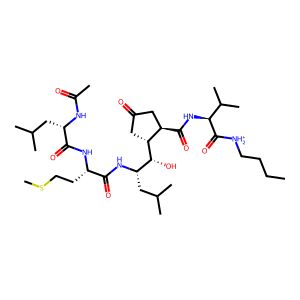

In [6]:
inhibitor = dataset[30]["smiles"]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

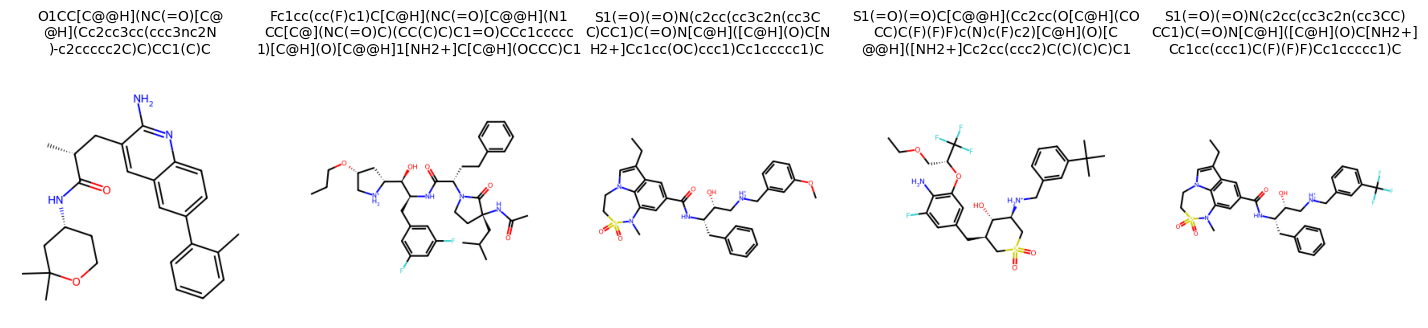

In [7]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
# mols = bace_df.sample(n=5, random_state=42)["mol"]
mols = dataset[:5]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols[i]["smiles"]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title, fontsize=10)

In [8]:
# Load a single graph

print(f"Number of nodes in graph is: {dataset[0].x.shape[0]}")
print(f"Number of features for each node is {dataset[0].num_features}")
print(f"Number of edges is {dataset[0].edge_index.shape[1]}")
print(f"Data object is {dataset[0]}\n")

Number of nodes in graph is: 32
Number of features for each node is 30
Number of edges is 70
Data object is Data(x=[32, 30], edge_index=[2, 70], edge_attr=[70, 11], Class=[1], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', pic50=9.1549015)



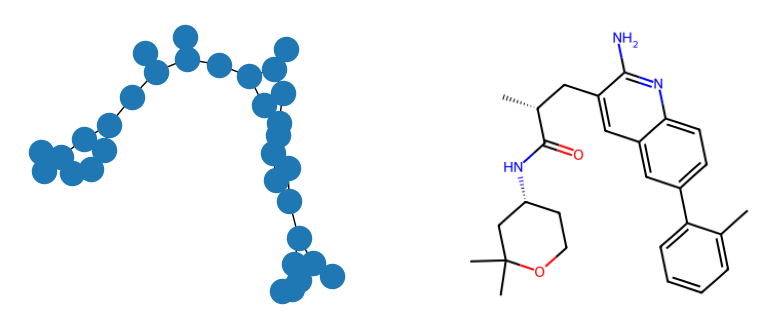

In [9]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (10,4))

g = torch_geometric.utils.to_networkx(dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [10]:
print(train_dataset.indices())
print(test_dataset.indices())

[812, 780, 1275, 897, 196, 1108, 845, 477, 1233, 1474, 581, 269, 1022, 967, 1031, 661, 1215, 1472, 150, 311, 281, 1509, 848, 1444, 84, 230, 571, 1296, 515, 1004, 190, 199, 511, 762, 642, 347, 971, 1005, 495, 1071, 252, 103, 36, 412, 994, 1312, 654, 777, 1121, 1494, 877, 1074, 1493, 1192, 530, 644, 1375, 1441, 711, 63, 746, 1339, 450, 1073, 1252, 1066, 299, 797, 23, 938, 429, 250, 741, 386, 1342, 734, 154, 1416, 336, 1044, 451, 172, 47, 1446, 513, 675, 828, 1331, 93, 794, 1129, 876, 912, 142, 374, 964, 659, 140, 194, 1295, 116, 706, 399, 528, 577, 690, 1450, 1196, 303, 175, 878, 1159, 817, 534, 976, 1290, 1177, 206, 1009, 233, 482, 197, 115, 339, 617, 808, 1512, 85, 977, 724, 899, 1245, 388, 953, 504, 109, 279, 929, 748, 1139, 468, 1425, 1206, 332, 923, 1455, 552, 1297, 1421, 1056, 280, 1113, 957, 851, 1255, 1382, 802, 662, 398, 1072, 312, 1321, 3, 310, 575, 137, 879, 637, 1440, 678, 158, 209, 781, 55, 186, 632, 960, 235, 1141, 663, 640, 1491, 1484, 593, 1214, 541, 728, 1033, 684, 826, 

Model parameters saved at epochs:
40
41
42
49
49


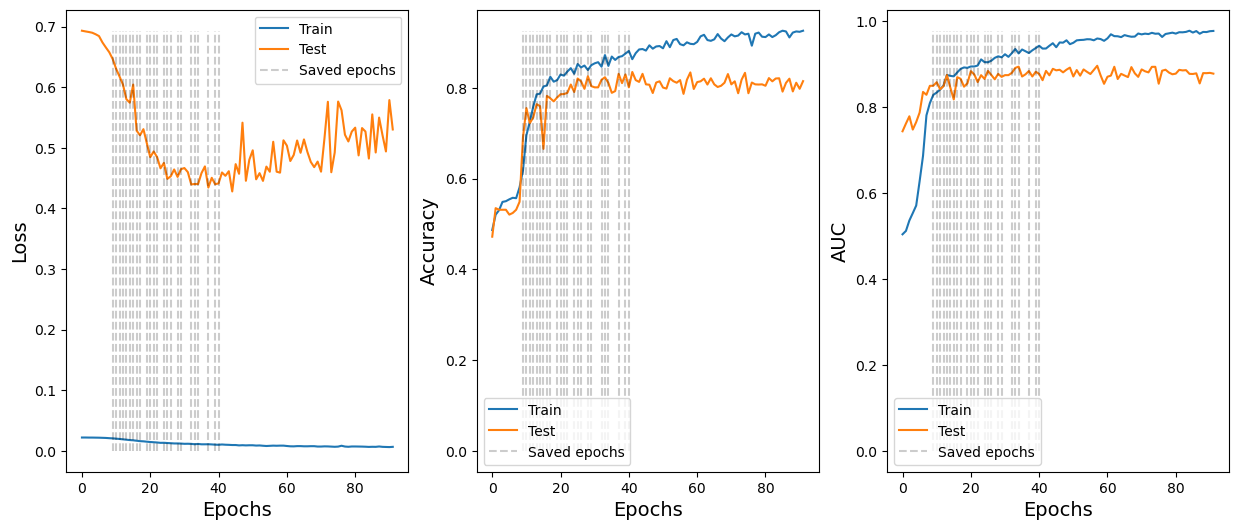

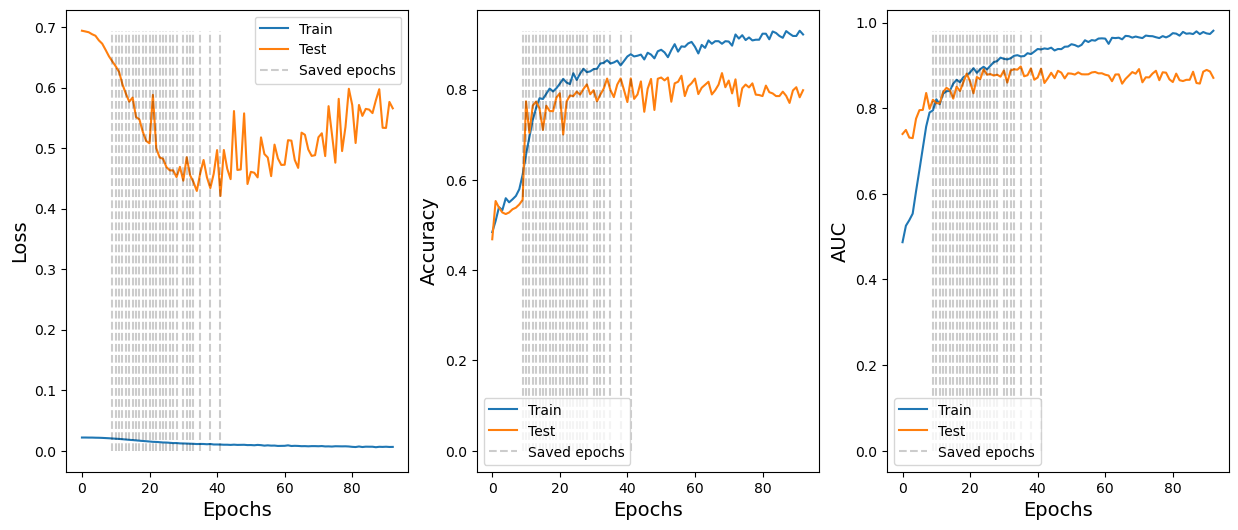

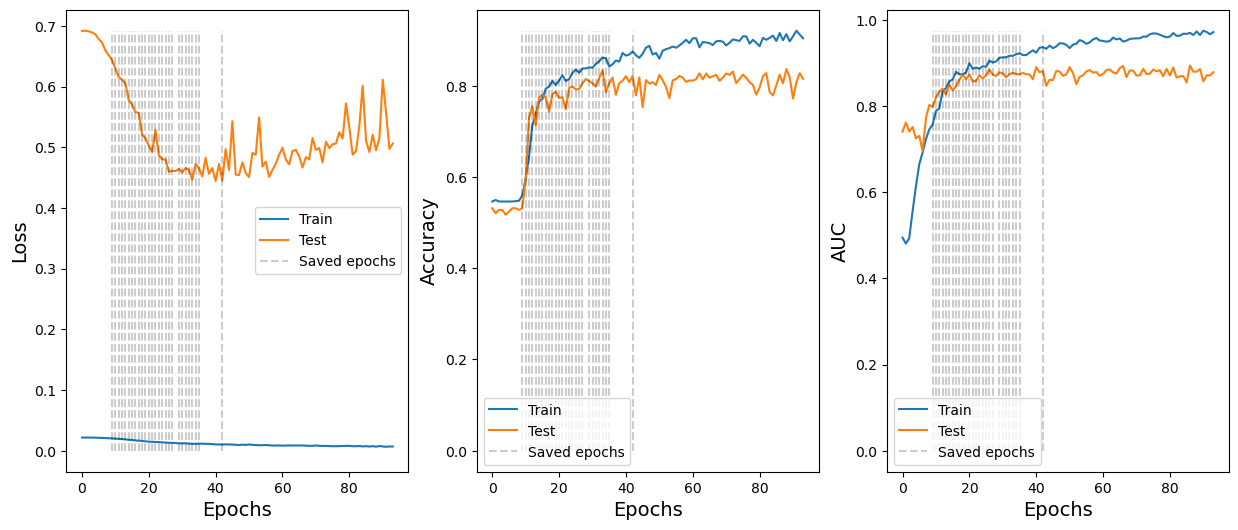

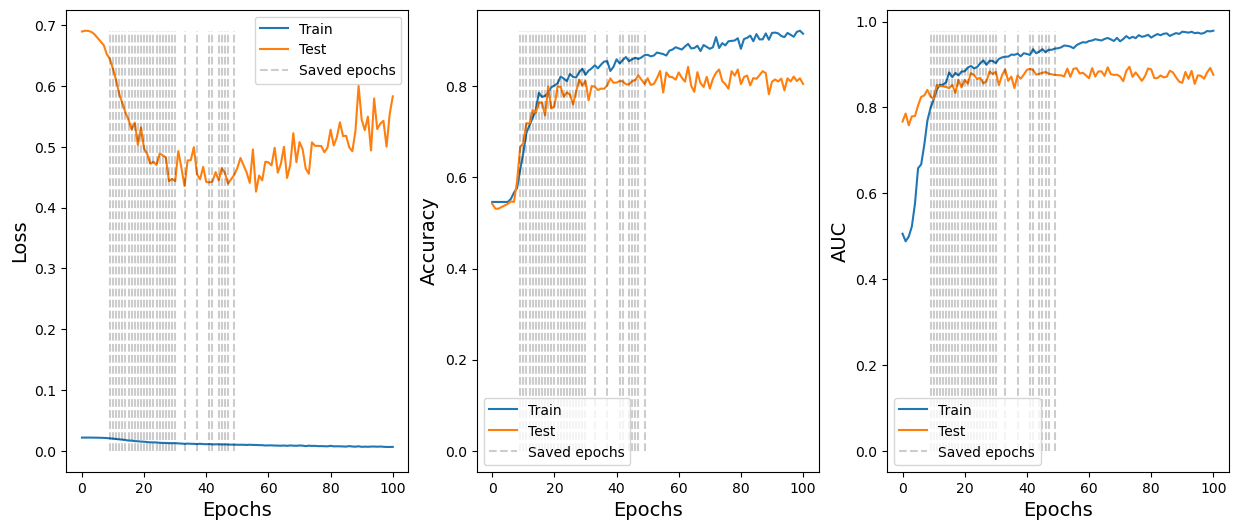

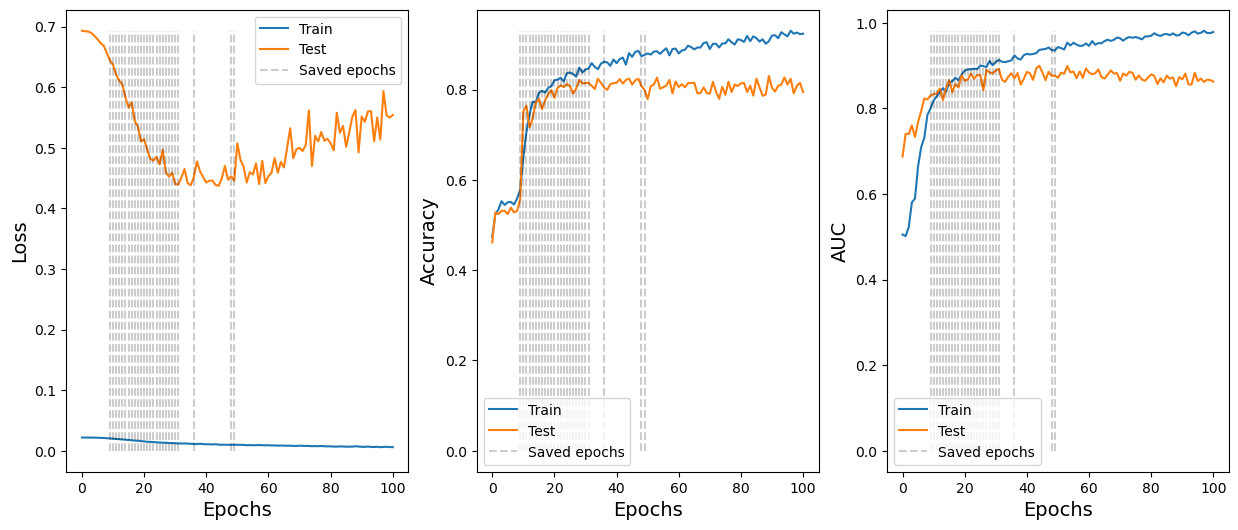

In [11]:
print("Model parameters saved at epochs:")
for i in range(0,5):
  with open(f'/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/models/new_ginconv_models/{i}_128_300_0.0001_global_mean_pool_results.pkl', 'rb') as func:
      loaded_dict = pickle.load(func)
  print(loaded_dict["saved_epochs"][-1])

  loss_acc_auc_plots(loaded_dict)

In [12]:
# Load a random GCN model to try new_metric_func on 
bace_gcn_models_path =  bace_models_path / "gcn_models"
model_save_path = bace_gcn_models_path/"0_128_300_global_mean_pool.pth"

loaded_model = GCNClassifier(30, 128, 2, global_mean_pool)



if torch.cuda.is_available():
  loaded_model.load_state_dict(torch.load(f=model_save_path))
else:
  loaded_model.load_state_dict(torch.load(f=model_save_path, map_location=torch.device('cpu')))

  loaded_model.eval()


0.8836 0.8071
Train Classification Report:


,precision,recall,f1-score,support
0.0,0.889968,0.832073,0.860047,661.000000
1.0,0.812500,0.876138,0.843120,549.000000
accuracy,0.852066,0.852066,0.852066,0.852066
macro avg,0.851234,0.854106,0.851583,1210.000000
weighted avg,0.854819,0.852066,0.852367,1210.000000


Test Classification Report:


,precision,recall,f1-score,support
0.0,0.797468,0.782609,0.789969,161.000000
1.0,0.758621,0.774648,0.766551,142.000000
accuracy,0.778878,0.778878,0.778878,0.778878
macro avg,0.778045,0.778628,0.778260,303.000000
weighted avg,0.779263,0.778878,0.778994,303.000000


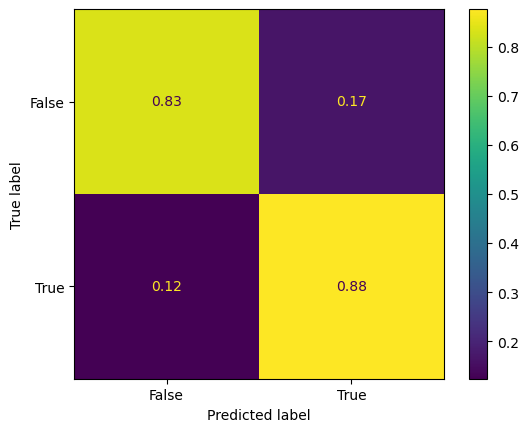

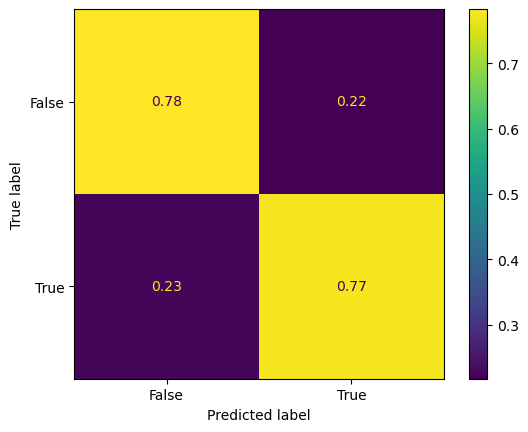

In [13]:

torch.manual_seed(42)
loaded_model = loaded_model.to(device)

train_auroc, test_auroc, train_classification_report, test_classification_report, train_confusion_matrix, test_confusion_matrix = new_metric_func(loaded_model, train_dataloader, test_dataloader, threshold=0.5)
print(round(train_auroc,4), round(test_auroc, 4))

print("Train Classification Report:")
display(train_classification_report)
print("Test Classification Report:")
display(test_classification_report)

cm_display_train = ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix, display_labels = ([False, True]))
cm_display_train.plot()

cm_display_test = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix, display_labels = ([False, True]))
cm_display_test.plot()


In [14]:
num_features = 30
num_hidden_channels = 128
num_out_channels = 2
heads = 4
num_layers = 3
edge_dim = 11
pool_method = global_mean_pool
use_edge_attr = True
nb_repeats = 5

gcn_model_skeleton = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
gat_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, False)
graphconv_model_skeleton = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)
ginconv_model_skeleton = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)
gineconv_model_skeleton = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)
gate_model_skeleton = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, True)

bace_gcn_models_path = bace_models_path / "gcn_models"
bace_gat_models_path = bace_models_path / "gat_models"
bace_graphconv_models_path = bace_models_path / "graphconv_models"
bace_ginconv_models_path = bace_models_path / "ginconv_models"
bace_gineconv_models_path = bace_models_path / "gineconv_models"
bace_gat_edge_models_path = bace_models_path / "gat_edge_models"
new_bace_ginconv_models_path = bace_models_path / "new_ginconv_models"
new_bace_gineconv_models_path = bace_models_path / "new_gineconv_models"

save_yes_no = False
auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(gineconv_model_skeleton, new_bace_gineconv_models_path, "_128_300_0.0001_global_mean_pool.pth", nb_repeats, save_yes_no, train_dataloader, test_dataloader, 128, 300, global_mean_pool, threshold=0.5)
print("Area under the curve metrics")
display(auroc_df)
print(f"Mean Train metrics from {nb_repeats} repeats")
display(mean_train_model_metrics)
print(f"Mean Test metrics from {nb_repeats} repeats")
display(mean_test_model_metrics)
print(f"Standard Deviation of train metrics from {nb_repeats} repeats") 
display(std_train_model_metrics)
print(f"Standard Deviation of test metrics from {nb_repeats} repeats")
display(std_test_model_metrics)

Area under the curve metrics


,Train,Test
0,0.943862,0.883169
1,0.003901,0.004788


Mean Train metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.874370,0.900151,0.886395,661.000000
1.0,0.876495,0.842259,0.857982,549.000000
accuracy,0.873884,0.873884,0.873884,0.873884
macro avg,0.875432,0.871205,0.872189,1210.000000
weighted avg,0.875334,0.873884,0.873504,1210.000000


Mean Test metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.771825,0.873292,0.818273,161.000000
1.0,0.832060,0.702817,0.759455,142.000000
accuracy,0.793399,0.793399,0.793399,0.793399
macro avg,0.801942,0.788054,0.788864,303.000000
weighted avg,0.800054,0.793399,0.790708,303.000000


Standard Deviation of train metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.029842,0.026399,0.006232,0.000000
1.0,0.023756,0.045402,0.014301,0.000000
accuracy,0.009046,0.009046,0.009046,0.009046
macro avg,0.008155,0.011589,0.009780,0.000000
weighted avg,0.009342,0.009046,0.009391,0.000000


Standard Deviation of test metrics from 5 repeats


,precision,recall,f1-score,support
0.0,0.040404,0.029658,0.012393,0.00000
1.0,0.020036,0.076725,0.039196,0.00000
accuracy,0.022090,0.022090,0.022090,0.02209
macro avg,0.014288,0.025182,0.025389,0.00000
weighted avg,0.015682,0.022090,0.024536,0.00000


In [15]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def threshold_metrics(thresholds, model_skeleton, model_path, save_true_false=False):
    precision_thresholds = []
    recall_thresholds = []
    for i in thresholds:
        auroc_df, mean_train_model_metrics, mean_test_model_metrics, std_train_model_metrics, std_test_model_metrics = average_model_metrics(model_skeleton, model_path, "_128_300_0.0001_global_mean_pool.pth", nb_repeats, save_yes_no, train_dataloader, test_dataloader, 128, 300, global_mean_pool, threshold=i)
        precision_thresholds.append(mean_test_model_metrics["precision"].loc["1.0"])
        recall_thresholds.append(mean_test_model_metrics["recall"].loc["1.0"])
    threshold_dict = {"thresholds": thresholds, "precision thresholds" : precision_thresholds, "recall thresholds": recall_thresholds}
    threshold_df = pd.DataFrame(threshold_dict)

    if save_true_false:
        threshold_df.to_pickle(model_path/'precision_recall_thresholds_distribution.pkl')


    return threshold_df

# gcn_threshold_metrics_df  = threshold_metrics(thresholds, gcn_model_skeleton, bace_gcn_models_path, save_true_false=True)
# gineconv_threshold_metrics_df  = threshold_metrics(thresholds, gineconv_model_skeleton, new_bace_gineconv_models_path, save_true_false=True)

In [16]:
gcn_threshold_metrics_df = pd.read_pickle("/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/models/gcn_models/precision_recall_thresholds_distribution.pkl")
gineconv_threshold_metrics_df = pd.read_pickle("/home/louis/Documents/personal_coding/graph_neural_networks/bace_dataset/models/gineconv_models/precision_recall_thresholds_distribution.pkl")


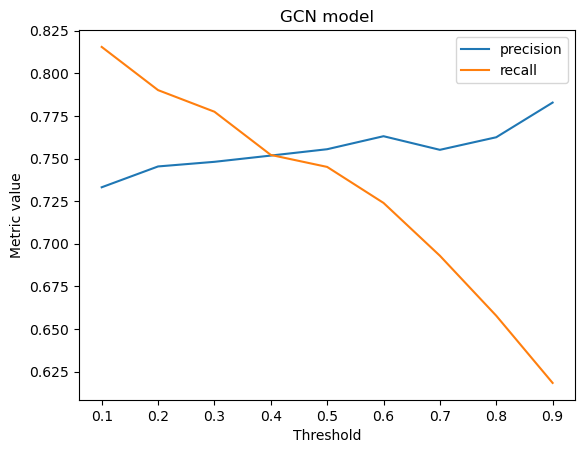

In [17]:
fig, ax = plt.subplots()

ax.plot(gcn_threshold_metrics_df["thresholds"], gcn_threshold_metrics_df["precision thresholds"], label = "precision")
ax.plot(gcn_threshold_metrics_df["thresholds"], gcn_threshold_metrics_df["recall thresholds"], label="recall")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric value")
ax.set_title("GCN model")
ax.legend()

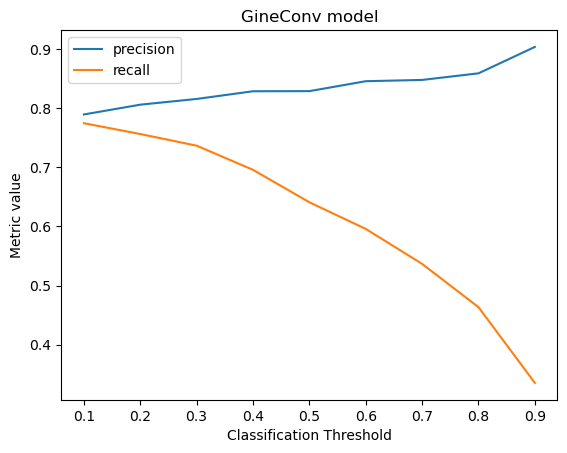

In [18]:
fig, ax = plt.subplots()

ax.plot(gineconv_threshold_metrics_df["thresholds"], gineconv_threshold_metrics_df["precision thresholds"], label = "precision")
ax.plot(gineconv_threshold_metrics_df["thresholds"], gineconv_threshold_metrics_df["recall thresholds"], label="recall")
ax.set_xlabel("Classification Threshold")
ax.set_ylabel("Metric value")
ax.set_title("GineConv model")
ax.legend()

/tmp/ipykernel_216778/2015068548.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


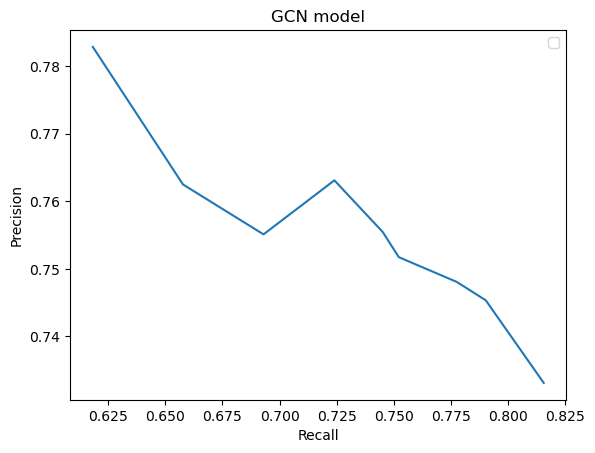

In [19]:
fig, ax = plt.subplots()

ax.plot(gcn_threshold_metrics_df["recall thresholds"], gcn_threshold_metrics_df["precision thresholds"])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("GCN model")
ax.legend()

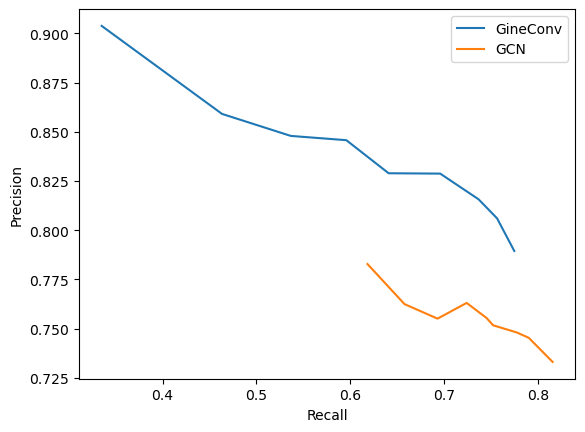

In [20]:
fig, ax = plt.subplots()

ax.plot(gineconv_threshold_metrics_df["recall thresholds"], gineconv_threshold_metrics_df["precision thresholds"], label = "GineConv")
ax.plot(gcn_threshold_metrics_df["recall thresholds"], gcn_threshold_metrics_df["precision thresholds"], label = "GCN")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()

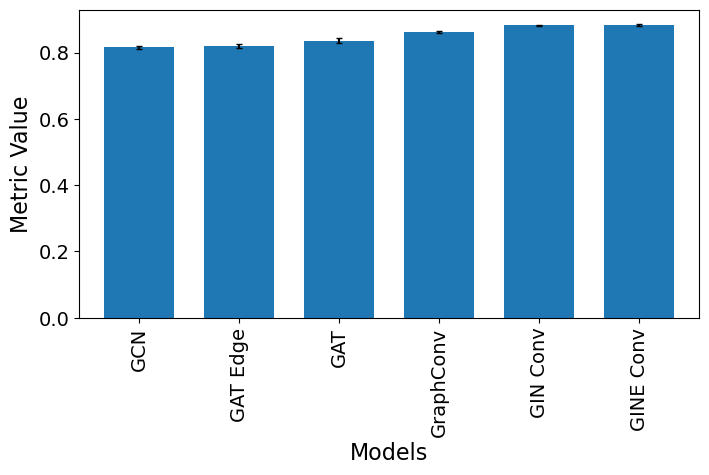

In [21]:
suffixes = {
        'auroc': "_auroc_df.pkl",
        'mean_train': "_mean_train_metrics.pkl",
        'mean_test': "_mean_test_metrics.pkl",
        'std_train': "_std_train_metrics.pkl",
        'std_test': "_std_test_metrics.pkl"
    }


models_metrics_df, models_metrics_error_df = plot_average_metrics(suffixes, 
    [bace_gcn_models_path, bace_gat_edge_models_path, bace_gat_models_path, bace_graphconv_models_path, 
    new_bace_ginconv_models_path, new_bace_gineconv_models_path],
    ["GCN", "GAT Edge", "GAT", "GraphConv","GIN Conv", "GINE Conv"],
     "auroc", bar_width = 0.7, show_legend = False, fontsize = 16, tick_labelsize = 14)



In [22]:
models_metrics_df

,GCN,GAT Edge,GAT,GraphConv,GIN Conv,GINE Conv
auroc,0.815405,0.820484,0.835579,0.862081,0.881918,0.883169
precision,0.762401,0.775684,0.787016,0.801411,0.799018,0.800054
recall,0.761716,0.775578,0.784818,0.800000,0.786799,0.793399
accuracy,0.761716,0.775578,0.784818,0.800000,0.786799,0.793399
f1-score,0.761144,0.775416,0.784651,0.799861,0.782347,0.790708
support,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
